##Preparing a Dataset for Creating a Heatmap with Seaborn
Our first task is to load that data and transform it into the form that Seaborn expects, and is easy for us to work with.

We will use the Pandas library for loading and manipulating data:

In [ ]:
import pandas as pd
data_url = "https://bit.ly/3cngqgL"
df = pd.read_csv(data_url,
                 parse_dates=['date_utc'],
                 dtype={'hour_utc':int,'minute_utc':int,'id':str}
                )

It's always worth using the head method to examine the first few rows of the DataFrame, to get familiar with its shape:

In [ ]:
df.head()

,id,username,date_utc,hour_utc,minute_utc,retweets
0,815422340540547073,realDonaldTrump,2017-01-01 05:00:10+00:00,5,0,27134
1,815930688889352192,realDonaldTrump,2017-01-02 14:40:10+00:00,14,40,23930
2,815973752785793024,realDonaldTrump,2017-01-02 17:31:17+00:00,17,31,14119
3,815989154555297792,realDonaldTrump,2017-01-02 18:32:29+00:00,18,32,3193
4,815990335318982656,realDonaldTrump,2017-01-02 18:37:10+00:00,18,37,7337


Here, we've printed the first 5 elements in the DataFrame. We have the index of each row first, followed by the id of the tweet, the username of the user who tweeted that tweet, as well as time-related information such as the date_utc, hour_utc and minute_utc.

Finally, we've got the number of retweets at the end, which can be used to check for interesting relationship between the contents of the tweets and the "attention" it got.

##Transforming the Data Into a Wide-Form DataFrame
It is common to find log data like this organized in a long (or tidy) form. This means there is a column for each variable, and each row of the data is a single observation (specific value) of those variables. Here, each tweet is each variable. Each row corresponds to one tweet and contains data about it.

But conceptually a heatmap requires that the data be organized in a short (or wide) form. And in fact the Seaborn library requires us to have the data in this form to produce heatmap visualizations.

Here, we've got hours as rows, as unique values, as well as minutes as columns. Each value in the cells is the number of tweet occurrences at that time. With this approach, we've only got 24 rows (24 hours) and 60 columns. If you imagine this spread visually, it essentially is a heatmap, though, with numbers.

In our example I want to understand if there are any patterns to how the candidates tweet at different times of the day. One way to do this is to count the tweets created in each the hour of the day and each minute of an hour.

Technically, we've got 2880 categories. Each combination of the hour_utc, minute_utc and username is a separate category, and we count the number of tweet occurrences for each of them.

This aggregation is straight-forward using Pandas. The hour and the minute of creation are available in the columns hour_utc and minute_utc. We can use the Pandas groupby() function to collect together all the tweets for each combination of username, hour_utc, and minute_utc:

In [ ]:
g = df.groupby(['hour_utc','minute_utc','username'])

#This means that only rows that have the same value of hour_utc, minute_utc, username can be considered an occurrence of the same category.

Now we can count the number of tweets in each group by applying the nunique() function to count the number of unique ids. This method avoids double counting any duplicate tweets that might lurk in the data, if it's not cleaned properly beforehand:

In [ ]:
tweet_cnt = g.id.nunique()
tweet_cnt.head()
#This gives us a Pandas Series with the counts we need to plot the heatmap:

hour_utc  minute_utc  username       
0         0           JoeBiden           26
                      realDonaldTrump     6
          1           JoeBiden           16
                      realDonaldTrump    11
          2           JoeBiden            6
Name: id, dtype: int64

To transform this into the wide-form DataFrame needed by Seaborn we can use the Pandas pivot() function.

For this example, it will be easiest to take one user at a time and plot a heatmap for each of them separately. We can put this on a single figure or separate ones.

Use the Pandas loc[] accessor to select one users tweet counts and then apply the pivot() function. It uses unique values from the specified index/columns to form axes of the resulting DataFrame. We'll pivot the hours and minutes so that the resulting DataFrame has a wide-spread form:

In [ ]:
jb_tweet_cnt = tweet_cnt.loc[:,:,'JoeBiden'].reset_index().pivot(index='hour_utc', columns='minute_utc', values='id')

In [ ]:
jb_tweet_cnt.iloc[:10,:9]
#Then take a peek at a section of the resulting DataFrame:

minute_utc,0,1,2,3,4,5,6,7,8
hour_utc,,,,,,,,,
0,26.0,16.0,6.0,7.0,4.0,24.0,2.0,2.0,9.0
1,24.0,7.0,5.0,6.0,4.0,19.0,1.0,2.0,6.0
2,3.0,3.0,3.0,NaN,5.0,1.0,4.0,8.0,NaN
3,3.0,3.0,3.0,4.0,5.0,1.0,3.0,5.0,4.0
4,1.0,1.0,1.0,2.0,NaN,NaN,1.0,1.0,1.0
5,1.0,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,7.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##Dealing with Missing Values
We can see above that our transformed data contains missing values. Wherever there were no tweets for a given minute/hour combination the pivot() function inserts a Not-a-Number (NaN) value into the DataFrame.

Furthermore pivot() does not create a row (or column) when there were no tweets at all for a particular hour (or minute).

See above where hours 7, 8 and 9 are missing.

This will be a common thing to happen when pre-processing data. Data might be missing, could be of odd types or entries (no validation), etc.

Seaborn can handle this missing data just fine, it'll just plot without them, skipping over hours 7, 8 and 9. However, our heatmaps will be more consistent and interpretable if we fill in the missing values. In this case we know that missing values are really a count of zero.

To fill in the NaNs that have already been inserted, use fillna() like so:

In [ ]:
jb_tweet_cnt.fillna(0, inplace=True)

To insert missing rows - make sure all hour and minute combinations appear in the heatmap - we'll reindex() the DataFrame to insert the missing indices and their values:

In [ ]:
# Ensure all hours in table
jb_tweet_cnt = jb_tweet_cnt.reindex(range(0,24), axis=0, fill_value=0)
# Ensure all minutes in table
jb_tweet_cnt = jb_tweet_cnt.reindex(range(0,60), axis=1, fill_value=0).astype(int)

Now we can complete our data preparation by repeating the same steps for the other candidates tweets:

In [ ]:
dt_tweet_cnt = tweet_cnt.loc[:,:,'realDonaldTrump'].reset_index().pivot(index='hour_utc', columns='minute_utc', values='id')
dt_tweet_cnt.fillna(0, inplace=True)
dt_tweet_cnt = dt_tweet_cnt.reindex(range(0,24), axis=0, fill_value=0)
dt_tweet_cnt = dt_tweet_cnt.reindex(range(0,60), axis=1, fill_value=0).astype(int)

##Creating a Basic Heatmap Using Seaborn
Now that we have prepared the data it is easy to plot a heatmap using Seaborn. First make sure you've imported the Seaborn library:

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

We'll also import Matplotlib's PyPlot module, since Seaborn relies on it as the underlying engine. After plotting plots with adequate Seaborn functions, we'll always call plt.show() to actually show these plots.

Now, as usual with Seaborn, plotting data is as simple as passing a prepared DataFrame to the function we'd like to use. Specifically, we'll use the heatmap() function.

Let's plot a simple heatmap of Trump's activity on Twitter:

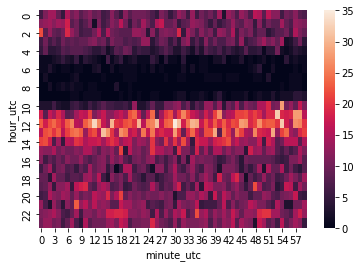

In [ ]:
sns.heatmap(dt_tweet_cnt)
plt.show()

And then Biden's:

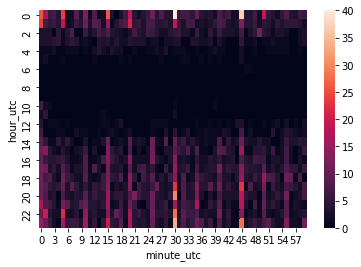

In [ ]:
sns.heatmap(jb_tweet_cnt)
plt.show()

The heatmaps produced using Seaborn's default settings are immediately usable. They show the same patterns as seen in the plots at the beginning of the guide, but are a bit more choppy, smaller and the axes labels appear in an odd frequency.

That aside, we can see these patterns because Seaborn does a lot of work for us, automatically, just by calling the heatmap() function:

It made appropriate choices of color palette and scale
It created a legend to relate colors to underlying values
It labeled the axes
These defaults may be good enough for your purposes and initial examination, as a hobbyist or data scientist. But oftentimes, producing a really effective heatmap requires us to customize the presentation to meet an audience's needs.

Let's take a look at how we can customize a Seaborn heatmap to produce the heatmaps seen in the beginning of the guide.

##How to Customize a Seaborn Heatmap
Using Color Effectively
The defining characteristic of a heatmap is the use of color to represent the magnitude of an underlying quantity.

It is easy to change the colors that Seaborn uses to draw the heatmap by specifying the optional cmap (colormap) parameter. For example, here is how to switch to the 'mako' color palette:

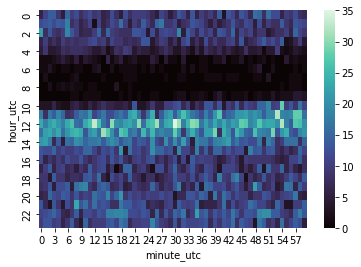

In [ ]:
sns.heatmap(dt_tweet_cnt, cmap="mako")
plt.show()

Seaborn provides many built-in palettes that you can choose from, but you should be careful to choose a good palette for your data and purpose.

For heatmaps showing numerical data - like ours - sequential palettes such as the default 'rocket' or 'mako' are good choices. This is because the colors in these palettes have been chosen to be perceptually uniform. This means the difference we perceive between two colors with our eyes is proportional to the difference between the underlying values.

The result is that by glancing at the map we can get a immediate feel for the distribution of values in the data.

A counter example demonstrates the benefits of a perceptually uniform palette and the pitfalls of poor palette choice. Here is the same heatmap drawn using the tab10 palette:

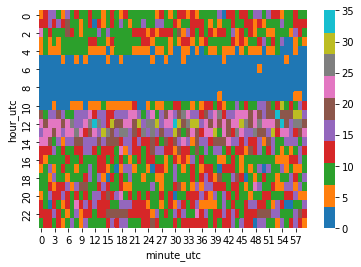

In [ ]:
sns.heatmap(dt_tweet_cnt, cmap="tab10")
plt.show()

This palette is a poor choice for our example because now we have to work really hard to understand the relationship between different colors. It has largely obscured the patterns that were previously obvious!

This is because the **tab10** palette is uses changes in hue to make it easy to distinguish between categories. It may be a good choice if the values of your heatmap were categorical.

If you are interested in both the low and high values in your data you might consider using a diverging palette like coolwarm or icefire which is a uniform scheme that highlights both extremes.

For more information on selecting color palettes, the Seaborn documentation has some useful guidance : http://seaborn.pydata.org/tutorial/color_palettes.html

##Control the Distorting Effect of Outliers
Outliers in the data can cause problems when plotting heatmaps. By default Seaborn sets the bounds of the color scale to the minimum and maximum value in the data.

This means an extremely large (or small) values in the data can cause details to be obscured. The more extreme the outliers, the farther away we are from a uniform coloring step. We've seen what effect this can have with the different colormaps.

One way to handle extreme values without having to remove them from the dataset is to use the optional robust parameter. Setting robust to True causes Seaborn to set the bounds of the color scale at the 2nd and 98th percentile values of the data, rather then the maximum and minimum. This will, in the vast majority of the cases, normalize the color spread into a much more usable state.

It is also possible to manually set the bounds of the color scale by setting the values of the parameters vmin and vmax. The can be very useful if you plan on having two heatmaps side by side and want to ensure the same color scale for each:

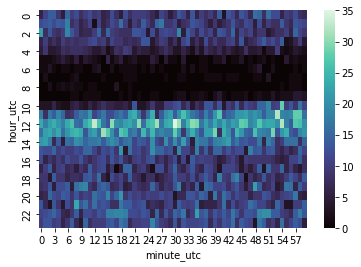

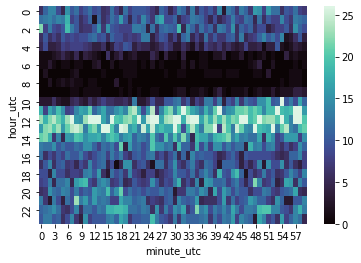

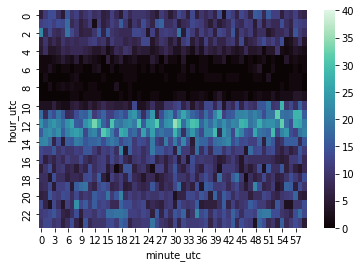

In [ ]:
sns.heatmap(dt_tweet_cnt, cmap="mako")
plt.show()

sns.heatmap(dt_tweet_cnt, cmap="mako",robust=True)
plt.show()

sns.heatmap(dt_tweet_cnt, cmap="mako", vmin=0, vmax=40)
plt.show()

##Adding Value Annotations
One downside of heatmaps is that making direct comparisons between values is difficult. A bar or line chart is a much easier way to do this.

However, it is possible to alleviate this problem by adding annotations to the heatmap to show the underlying values. This is easily done in Seaborn by setting the annot parameter to True, like this:

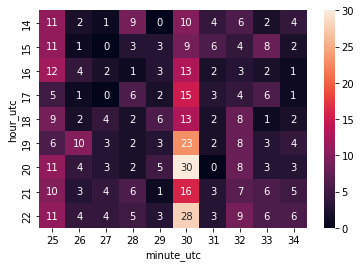

In [ ]:
sns.heatmap(jb_tweet_cnt.iloc[14:23,25:35], annot=True)
plt.show()

##Categorical Heatmaps in Seaborn

There are times when it's useful to simplify a heatmap by putting numerical data into categories. For example we could bucket the tweet count data into just three categories 'high', 'medium', and 'low', instead of a numerical range such as 0..40.

Unfortunately at the time of writing, Seaborn does not have the built-in ability to produce heatmaps for categorical data like this as it expects numerical input. Here's a code snippet that shows it is possible to "fake "it with a little palette and color bar hacking.

Although this is one circumstance where you may want to consider the merit of other visualization packages that have such features built-in.

We'll use a helping hand from Matplotlib, the underlying engine underneath Seaborn since it has a lot of low-level customization options and we have full access to it. Here, we can "hack" the legend on the right to display values we'd like:

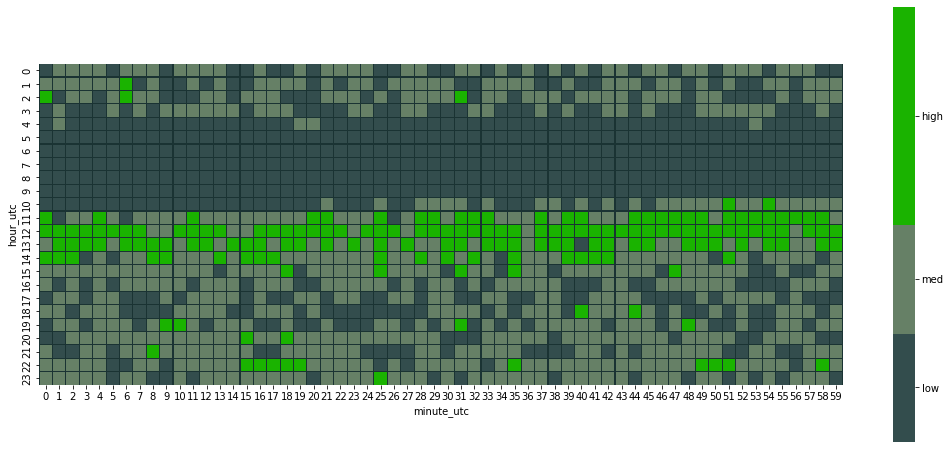

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize=(18,8))
my_colors=[(0.2,0.3,0.3),(0.4,0.5,0.4),(0.1,0.7,0),(0.1,0.7,0)]

sns.heatmap(dt_tweet_cnt, cmap=my_colors, square=True, linewidth=0.1, linecolor=(0.1,0.2,0.2), ax=ax)

colorbar = ax.collections[0].colorbar
M=dt_tweet_cnt.max().max()
colorbar.set_ticks([1/8*M,3/8*M,6/8*M])
colorbar.set_ticklabels(['low','med','high'])

plt.show()

## Preparing Heatmaps for Presentation
A couple of last steps to put the finishing touches on your heatmap.

Using Seaborn Context to Control Appearance
The set_context() function provides a useful way to control some of the elements of the plot without changing its overall style. For example it can be a convenient way to customize font sizes and families.
There are several preset contexts available:https://seaborn.pydata.org/generated/seaborn.set_context.html

In [ ]:
sns.set_context("notebook", font_scale=1.75, rc={"lines.linewidth": 2.5, 'font.family':'Helvetica'})

## Using Subplots to Control the Layout of Heatmaps
The final step in creating our tweet count heatmap is to put the two plots next to each other in a single figure so it is easy to make comparisons between them.

We can use the subplot() feature of matplotlib.pyplot to control the layout of heatmaps in Seaborn. This will give you maximum control over the final graphic and allow for easy export of the image.

Creating subplots using Matplotlib is as easy as defining their shape (2 subplots in 1 column in our case):

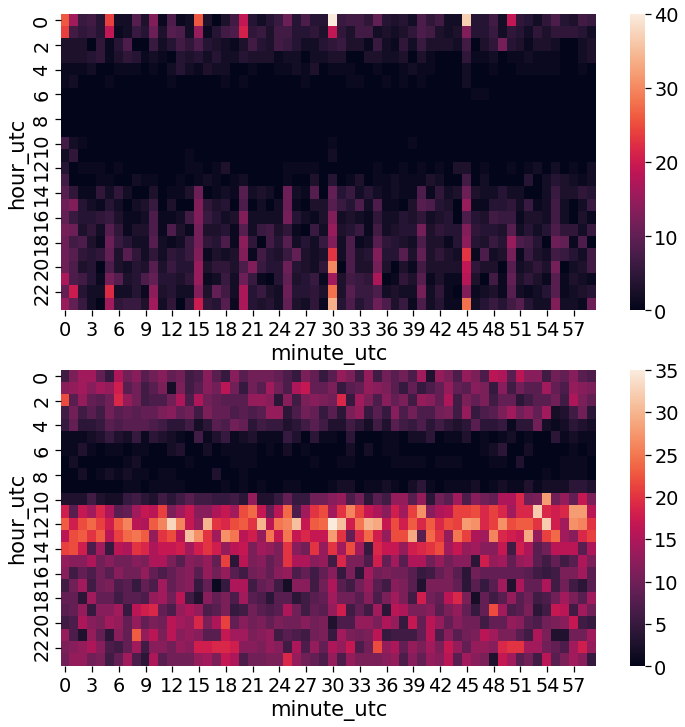

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
sns.heatmap(jb_tweet_cnt, ax=ax1)
sns.heatmap(dt_tweet_cnt, ax=ax2)

plt.show()

This is essentially it, although, lacks some of the styling we've seen in the beginning. Let's bring together many of the customizations we have seen in the guide to produce our final plot and export it as a .png for sharing:

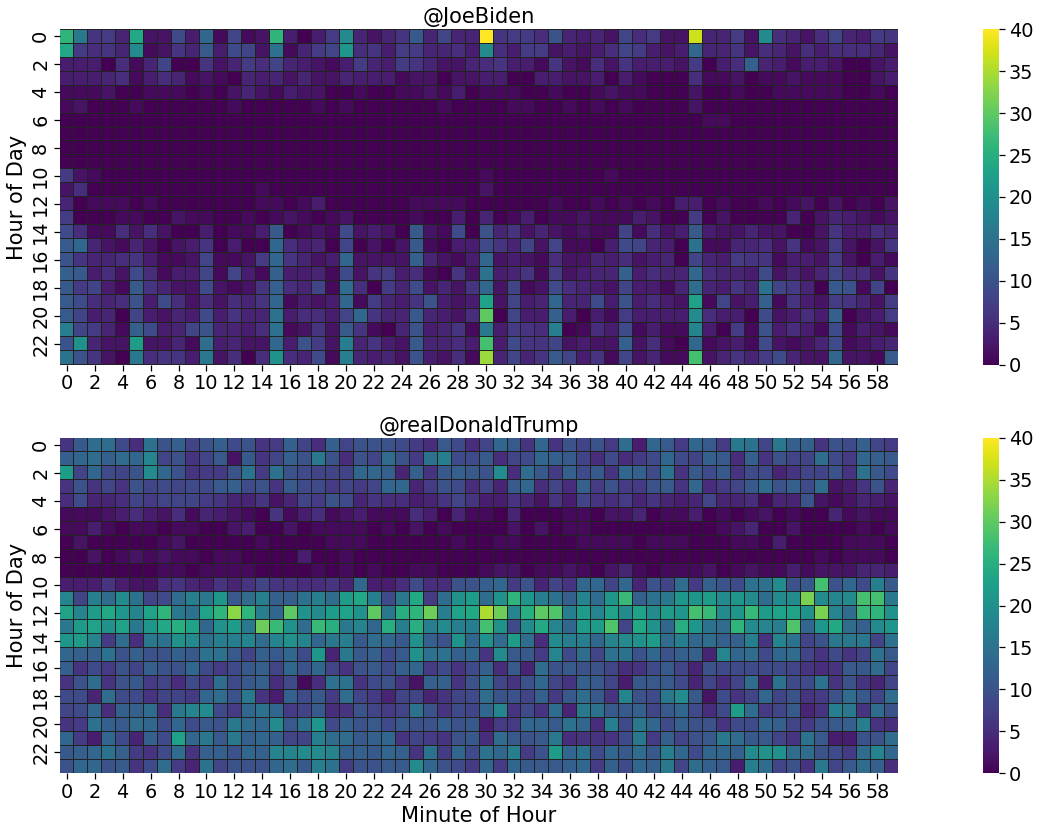

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(24,12))

for i,d in enumerate([jb_tweet_cnt,dt_tweet_cnt]):

    labels = d.applymap(lambda v: str(v) if v == d.values.max() else '')
    sns.heatmap(d,
                cmap="viridis",  # Choose a squential colormap
                #annot=jb_labels, # Label the maximum value
                annot_kws={'fontsize':11},  # Reduce size of label to fit
                fmt='',          # Interpret labels as strings
                square=True,     # Force square cells
                vmax=40,         # Ensure same
                vmin=0,          # color scale
                linewidth=0.01,  # Add gridlines
                linecolor="#222",# Adjust gridline color
                ax=ax[i],        # Arrange in subplot
               )

ax[0].set_title('@JoeBiden')
ax[1].set_title('@realDonaldTrump')
ax[0].set_ylabel('Hour of Day')
ax[1].set_ylabel('Hour of Day')
ax[0].set_xlabel('')
ax[1].set_xlabel('Minute of Hour')
plt.tight_layout()
plt.savefig('final.png', dpi=120)

##Conclusion
In this guide we looked at heatmaps and how to create them with Python and the Seaborn visualization library.

The strength of heatmaps is in the way they use color to get information across, in other words, it makes it easy for anyone to see broad patterns at a glance.

We've seen how in order to do this we have to make careful selections of color palette and scale. We've also seen that there are number of options available for customizing a heatmap using Seaborn in order to emphasize particular aspects of the chart. These include annotations, grouping and ordering categorical axes, and layout.

As always, editorial judgment on the part of the Data Visualizer is required to choose the most appropriate customizations for the context of the visualization.